### Constraint-based Chain-of-States methods on a Muller potential surface. 

**Authors: Zilin Song**

#### a. Imports

In [1]:
# Generic Python.
import sys
sys.dont_write_bytecode = True
from typing import Type, List

# PyCoSPath
from pycospath.cos import   ConstAdvRep          as car,   \
                            ConstAdvRepParamTan  as carpt, \
                            ReaxPathCons         as rpc,   \
                            ReaxPathConsGradProj as rpcgp, \
                            StringMethod         as sm,    \
                            StringMethodGradProj as smgp,  \
                            CosBase

from pycospath.chain import Chain2D
from pycospath.comms.twodim import Rep2D, PotMuller
from pycospath.opt import ConsGradientDescent

# Misc.
import numpy
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns

#### b. Calculations

In [2]:
def exec_cos(cosname: str):
    """Execute the cos descent and record the descending trajectories. """

    # Control vars.
    n_reps  = 21   # Number of replicas on the chain.
    n_steps = 100  # Number of descending steps per optimization phase. 

    # Initialize cos optimization. 
    pot = PotMuller()

    ## Linear interception between (0, 0) and (0, 2)
    xs = numpy.zeros((n_reps, ))
    ys = numpy.linspace(0, 2, num=n_reps)

    ## Make a list of Replicas. 
    rep_list = []

    for i_rep in range(n_reps):
        coor = numpy.asarray([xs[i_rep], ys[i_rep]])
        rep = Rep2D(coor, pot)
        rep_list.append(rep)

    chain = Chain2D(rep_list)

    cos = car  (chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/car_cons.log'  , 'w')) if cosname == 'car'   else \
          carpt(chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/carpt_cons.log', 'w')) if cosname == 'carpt' else \
          rpc  (chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/rpc_cons.log'  , 'w')) if cosname == 'rpc'   else \
          rpcgp(chain, verbose=False, cons_log_writer=open('./ms0_car/fig_muller/rpcgp_cons.log', 'w')) if cosname == 'rpcgp' else \
          sm   (chain)                                                                                  if cosname == 'sm'    else \
          smgp (chain)


    opt = ConsGradientDescent(cos)

    # Initial chain_vec
    init_cvec = chain.get_chain_vec()

    # Trajectory of chain_vec
    traj_cvec = []

    # Evolve the cos and record the chain_vec per step. 
    ## 100 steps with fixed leanring rate.
    for _ in range(n_steps):
        opt.step()
        traj_cvec.append(chain.get_chain_vec())

    ## 100 steps with down-scaling learning rate.
    opt._gd_eta_scal = .98
    for _ in range(n_steps):
        opt.step()
        traj_cvec.append(chain.get_chain_vec())
    
    # Final chain_vec
    finl_cvec = chain.get_chain_vec()

    return init_cvec, traj_cvec, finl_cvec

In [3]:
# **NOTE: Performance bottleneck: do not clear outputs.**

out_car   = exec_cos('car')
out_carpt = exec_cos('carpt')
out_rpc   = exec_cos('rpc')
out_rpcgp = exec_cos('rpcgp')
out_sm    = exec_cos('sm')
out_smgp  = exec_cos('smgp')

#### c. Extract no. iterations and RMS deviations

In [4]:
from pycospath.utils import rms

def load_itr_counts(method:str):
    """Load the number of iterative coordinate updates for the method.
    method: 'car' or 'rpc'. 
    """
    fi = open(f'./ms0_car/fig_muller/{method}_cons.log', 'r')

    step_count_list = []
    for l in fi.readlines():
        step_count_list.append(int(l.split()[1]))
        
    return step_count_list

def load_rms_deviations(method:str, traj_cvec:List[numpy.ndarray]=None):
    """Load the rms deviations of the updated constraint coordinates. 
    method: 'car', 'rpc' or 'sm'. 
    traj_cvec: traj_cvec of the (Simplified) String Method. 
    """
    traj_rms_dv = []
        
    for i_step in range(len(traj_cvec)):
        cvec = traj_cvec[i_step]
        cvec_rms = rms(cvec, wscale=numpy.ones(2, ), redund=2, return_grads=False)
        traj_rms_dv.append(numpy.max(numpy.abs(cvec_rms - numpy.mean(cvec_rms))))
        
    return traj_rms_dv

In [5]:
# Load iterative steps and RMS deviations.
itr_coor_steps_car   = load_itr_counts('car')
itr_coor_steps_carpt = load_itr_counts('carpt')
itr_coor_steps_rpc   = load_itr_counts('rpc')
itr_coor_steps_rpcgp = load_itr_counts('rpcgp')

rms_dev_car   = load_rms_deviations('car',   traj_cvec=out_car  [1])
rms_dev_carpt = load_rms_deviations('carpt', traj_cvec=out_carpt[1])
rms_dev_rpc   = load_rms_deviations('rpc',   traj_cvec=out_rpc  [1])
rms_dev_rpcgp = load_rms_deviations('rpcgp', traj_cvec=out_rpcgp[1])
rms_dev_sm    = load_rms_deviations('sm',    traj_cvec=out_sm   [1])
rms_dev_smgp  = load_rms_deviations('smgp',  traj_cvec=out_smgp [1])

In [6]:
def plot_cvec(ax: Axes, 
              init: numpy.ndarray, 
              traj: List[numpy.ndarray], 
              finl: numpy.ndarray) -> Axes:
    """Plot the cos calculations. """
    # Plot Muller PES
    pot = PotMuller()
    x, y, v = pot.get_pes(ecut=75)

    v = ax.contourf(x, y, v, 20, extend='both', cmap=sns.color_palette("YlGnBu_r", as_cmap=True))

    # Plot init cvec. 
    ax.plot(init[:, 0], init[:, 1], color="#9A1663", marker='.', markersize=7,  zorder=5)

    # Plot trajectory of cvec.
    for t in traj:
        ax.plot(   t[:, 0], t[:, 1], color="#888888", marker='.', markersize=1, lw=.5, zorder=4)
    
    # Plot final cvec.
    ax.plot(finl[:, 0], finl[:, 1], color="#FF97C1", marker='.', markersize=7, zorder=5)
    
    # Ticks and scale.
    ax.set(xlim=(-1.3, 1.1), xticks=(-1.3, -0.1, 1.1),
           ylim=(-0.2, 2.2), yticks=(-0.2,  1.0, 2.2))

    
    ax.tick_params(top=True, right=True, direction='in', width=1.5, length=4, labelsize=12)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_aspect('equal', adjustable='box')
    
    return ax, v

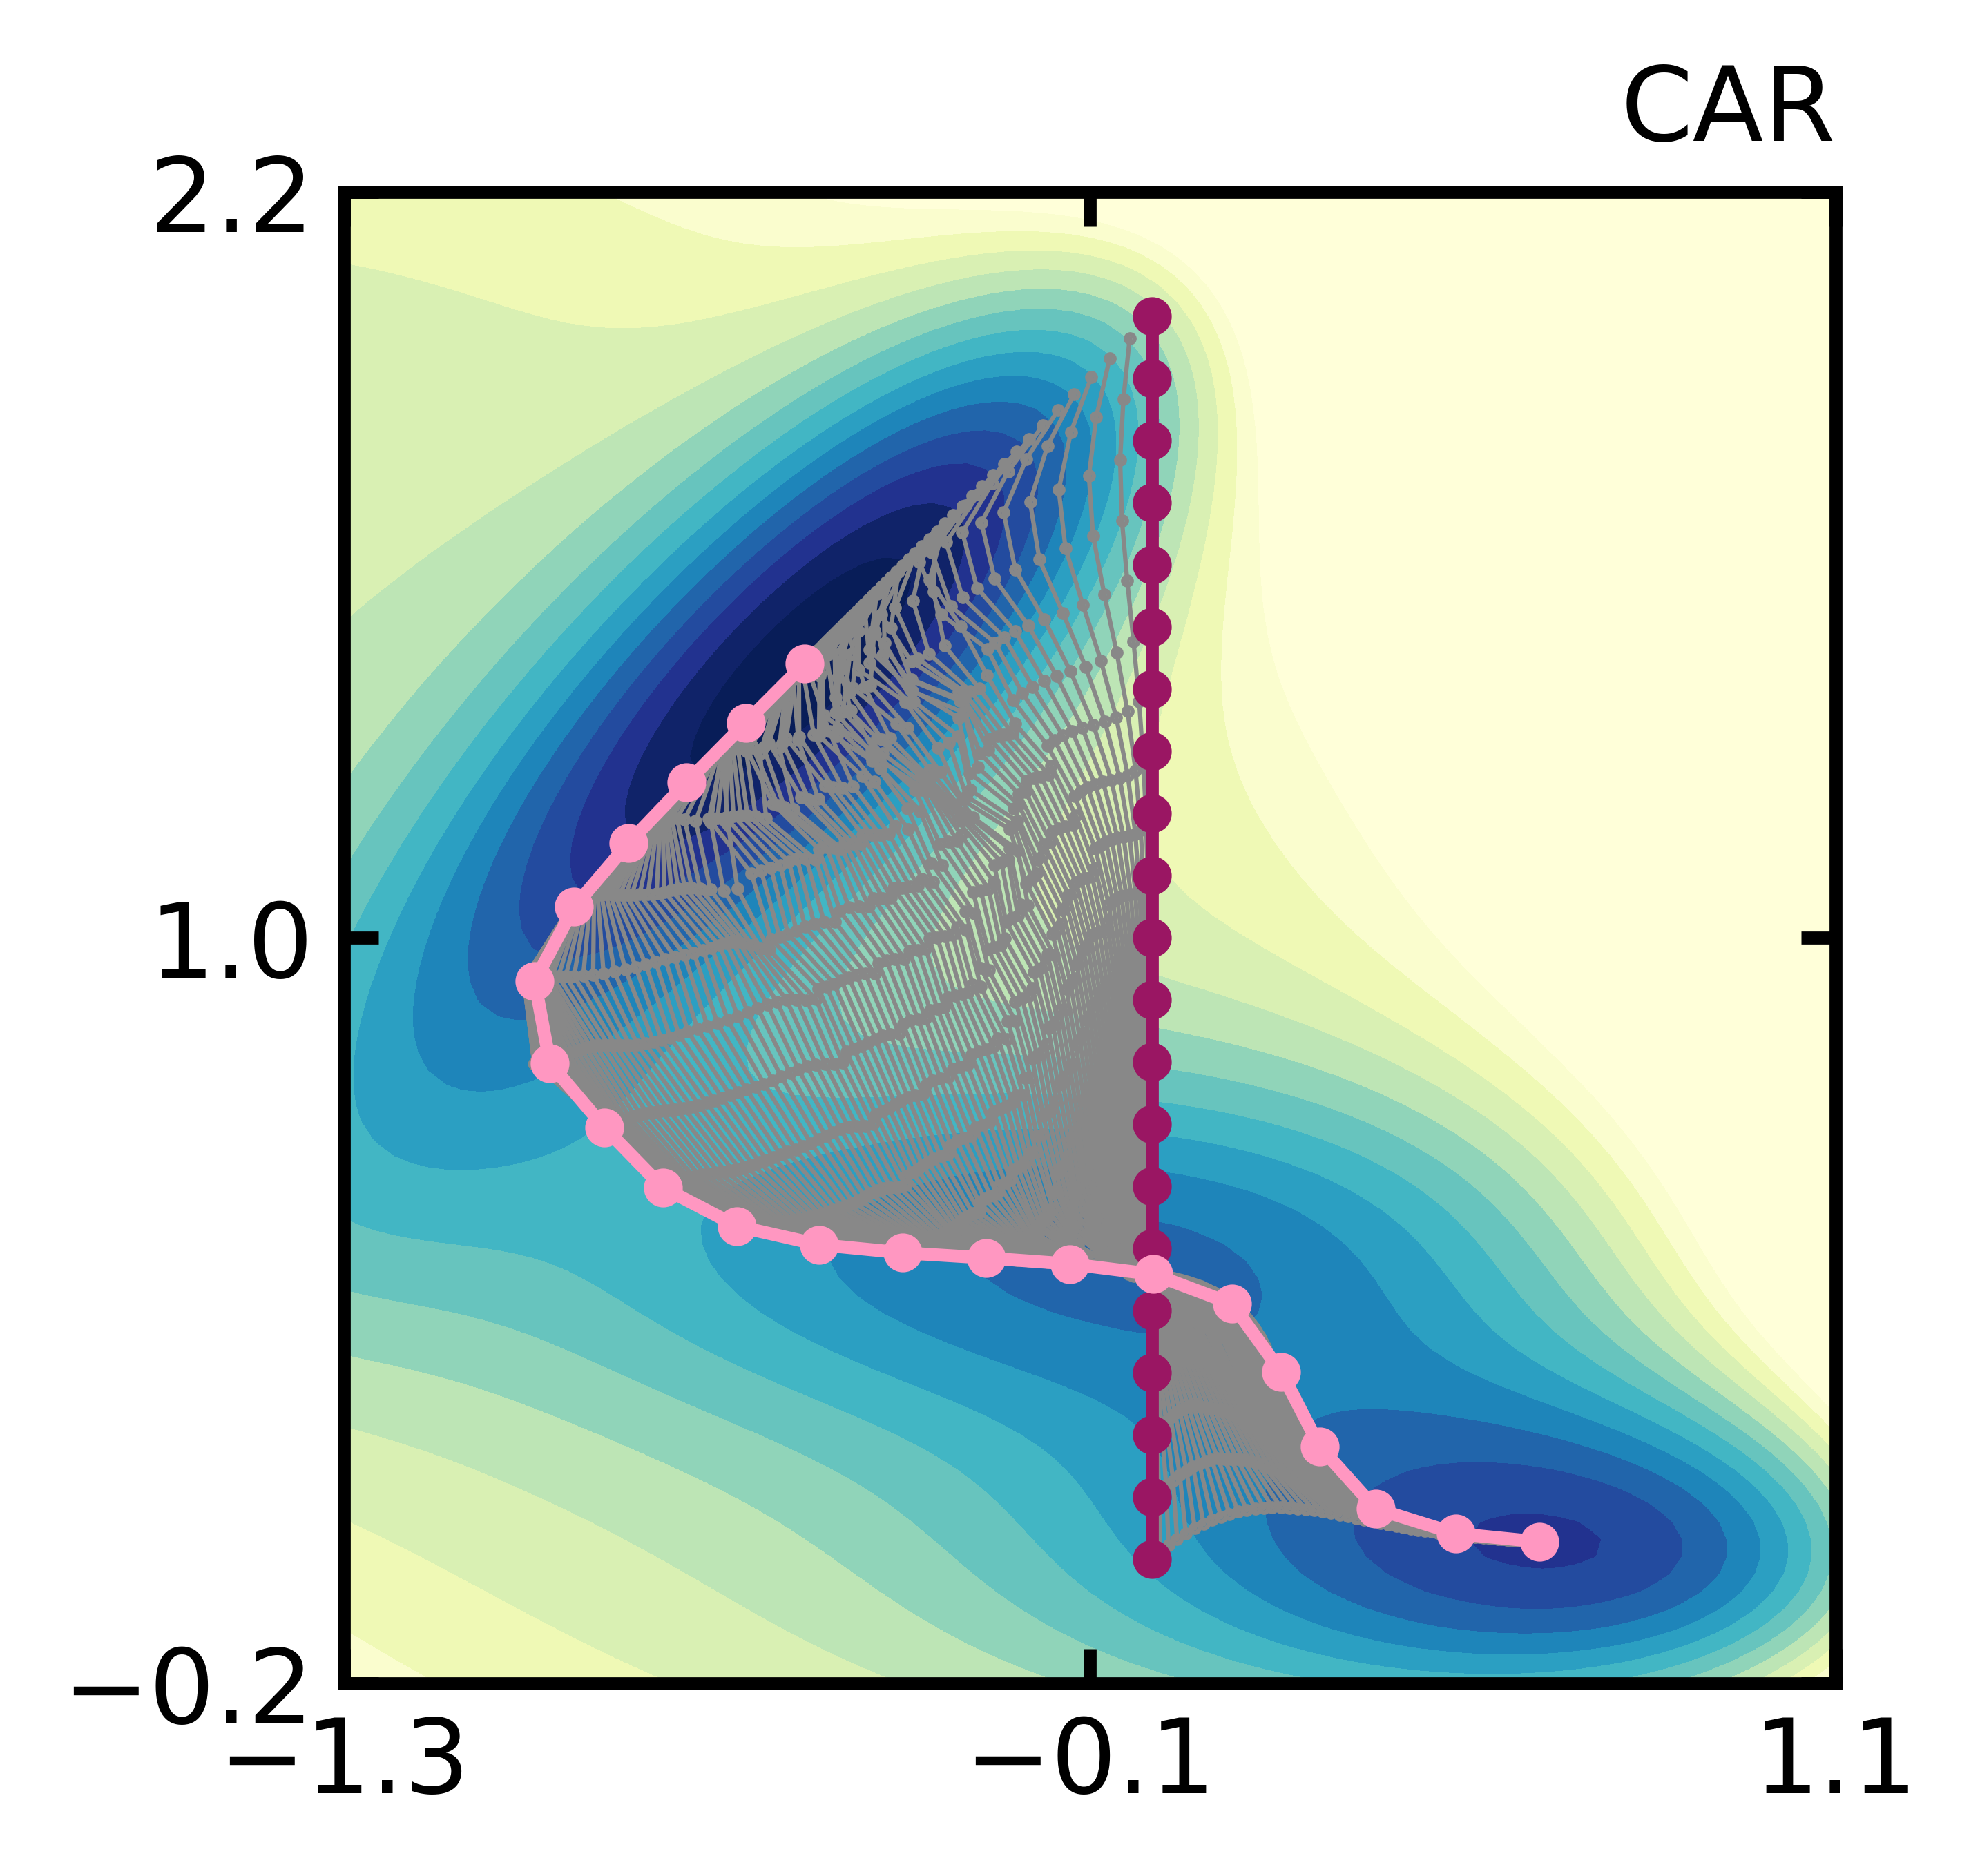

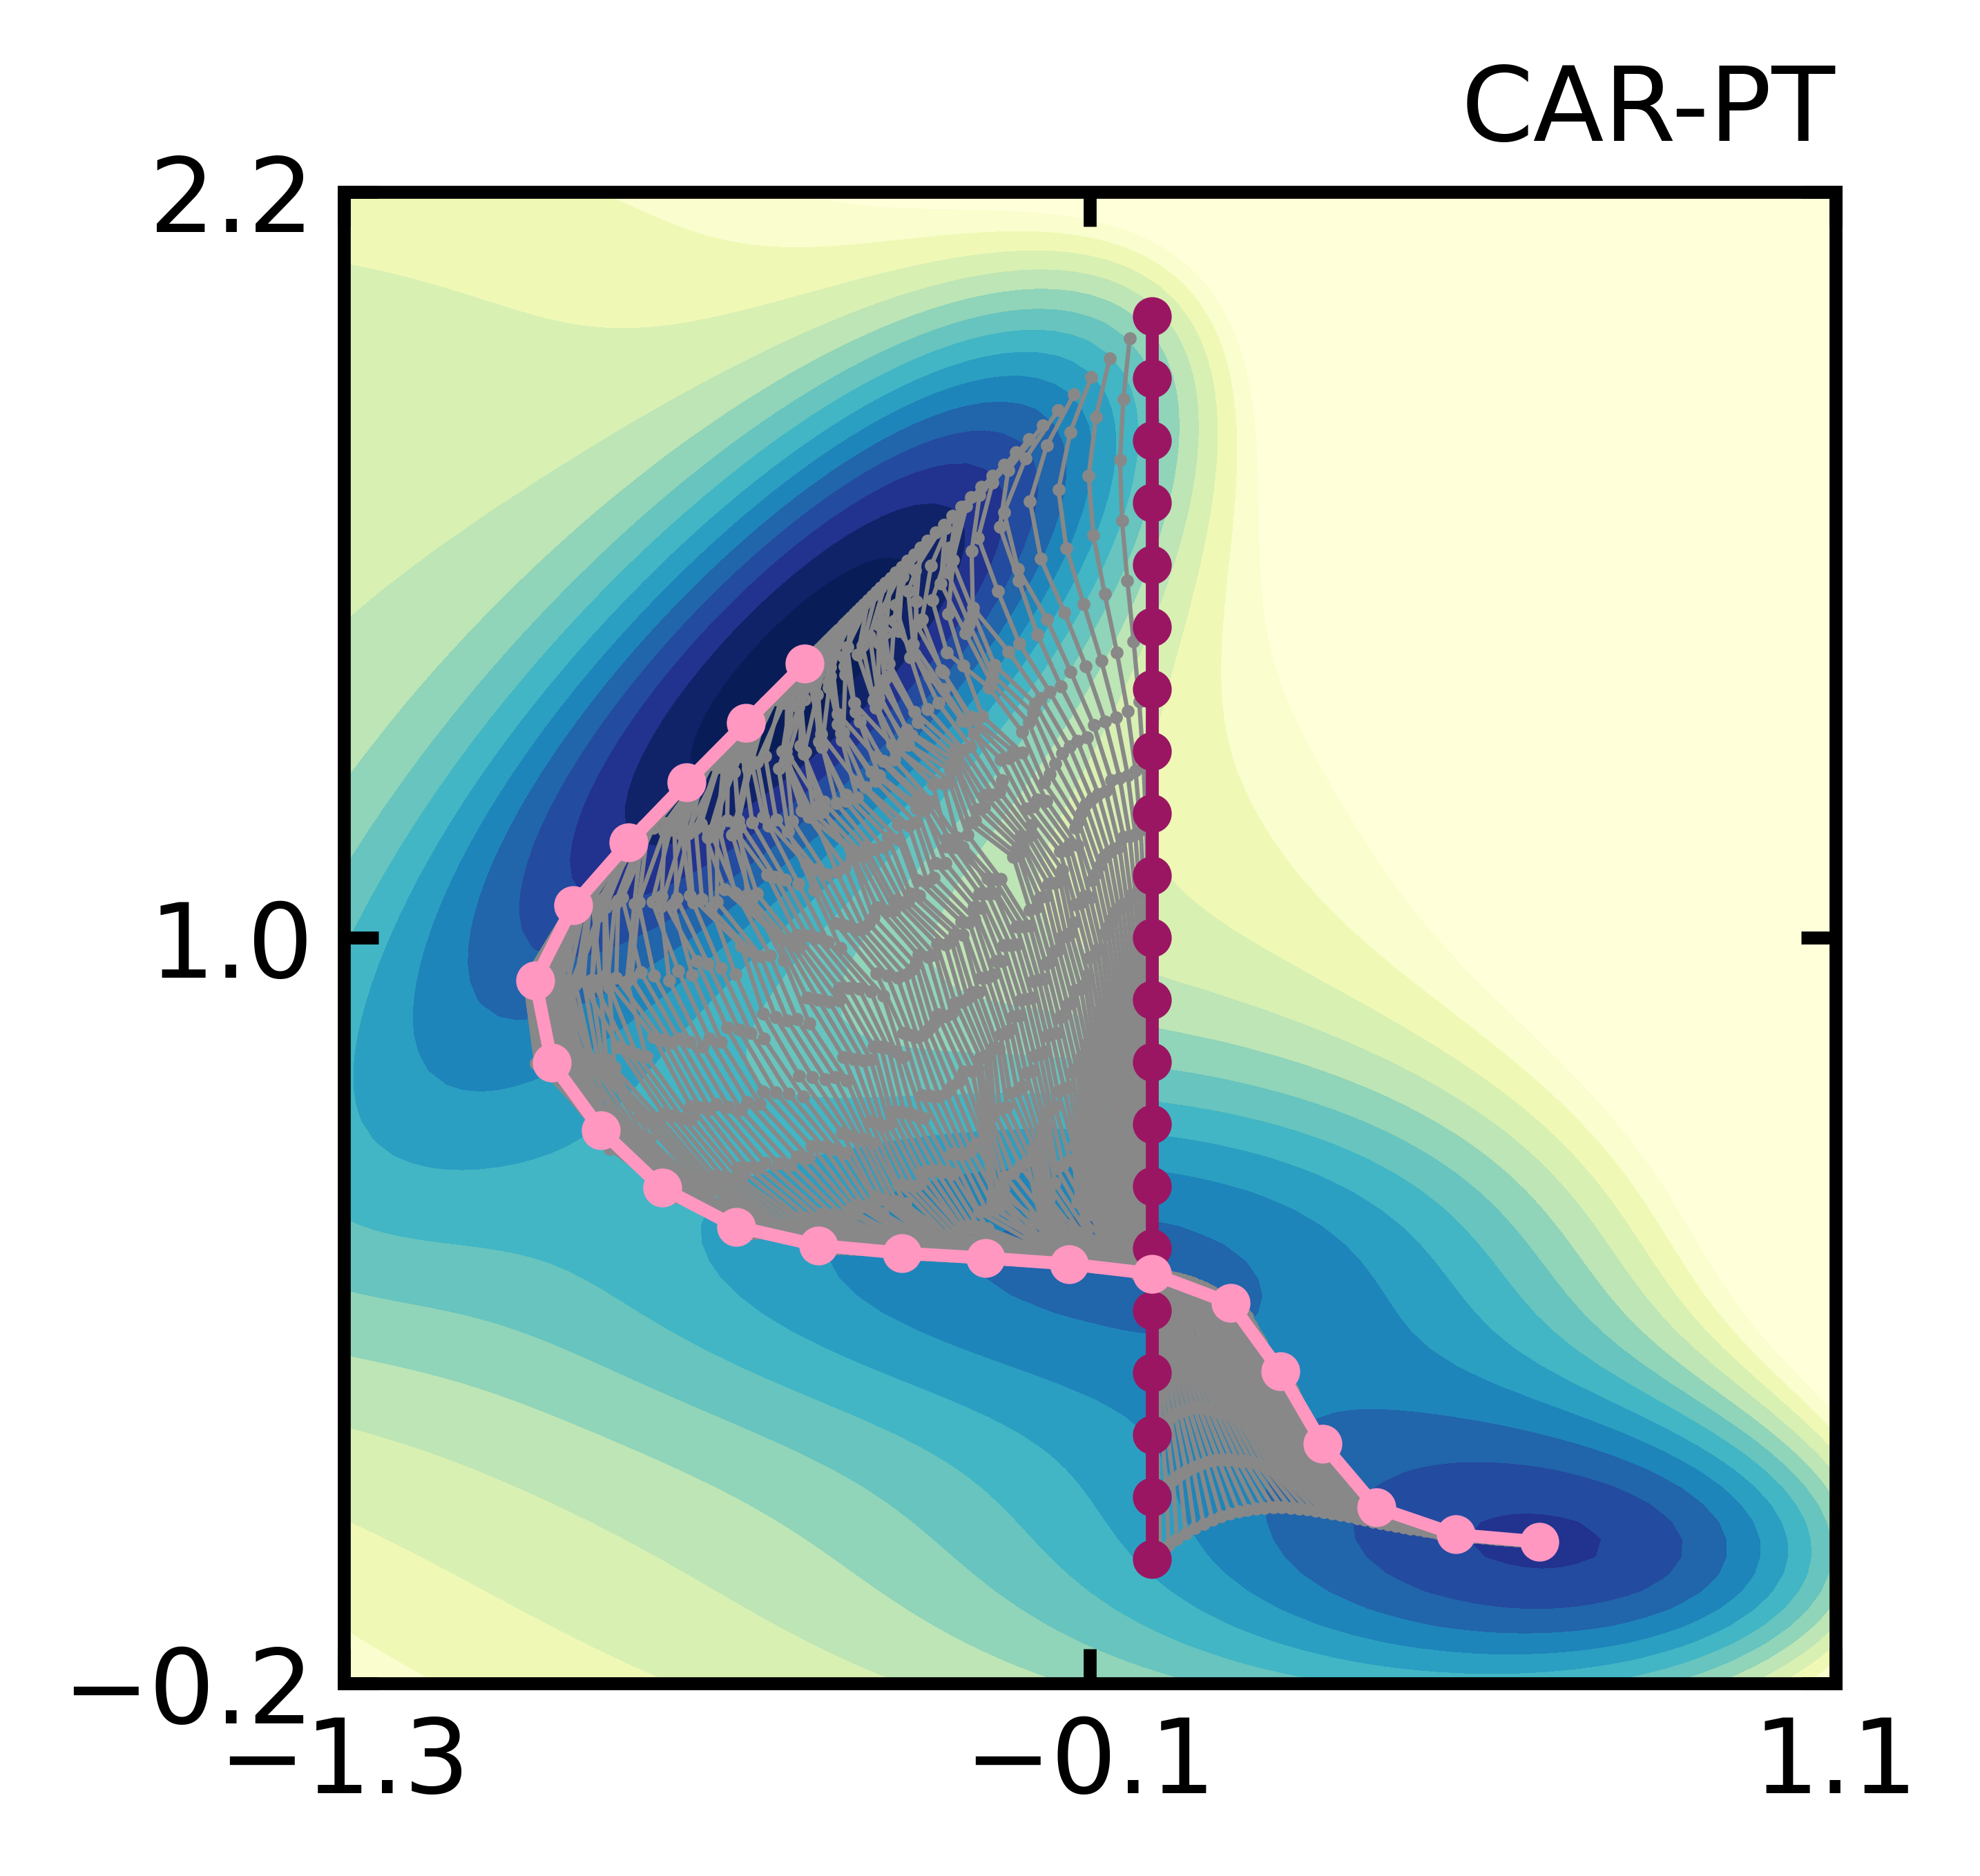

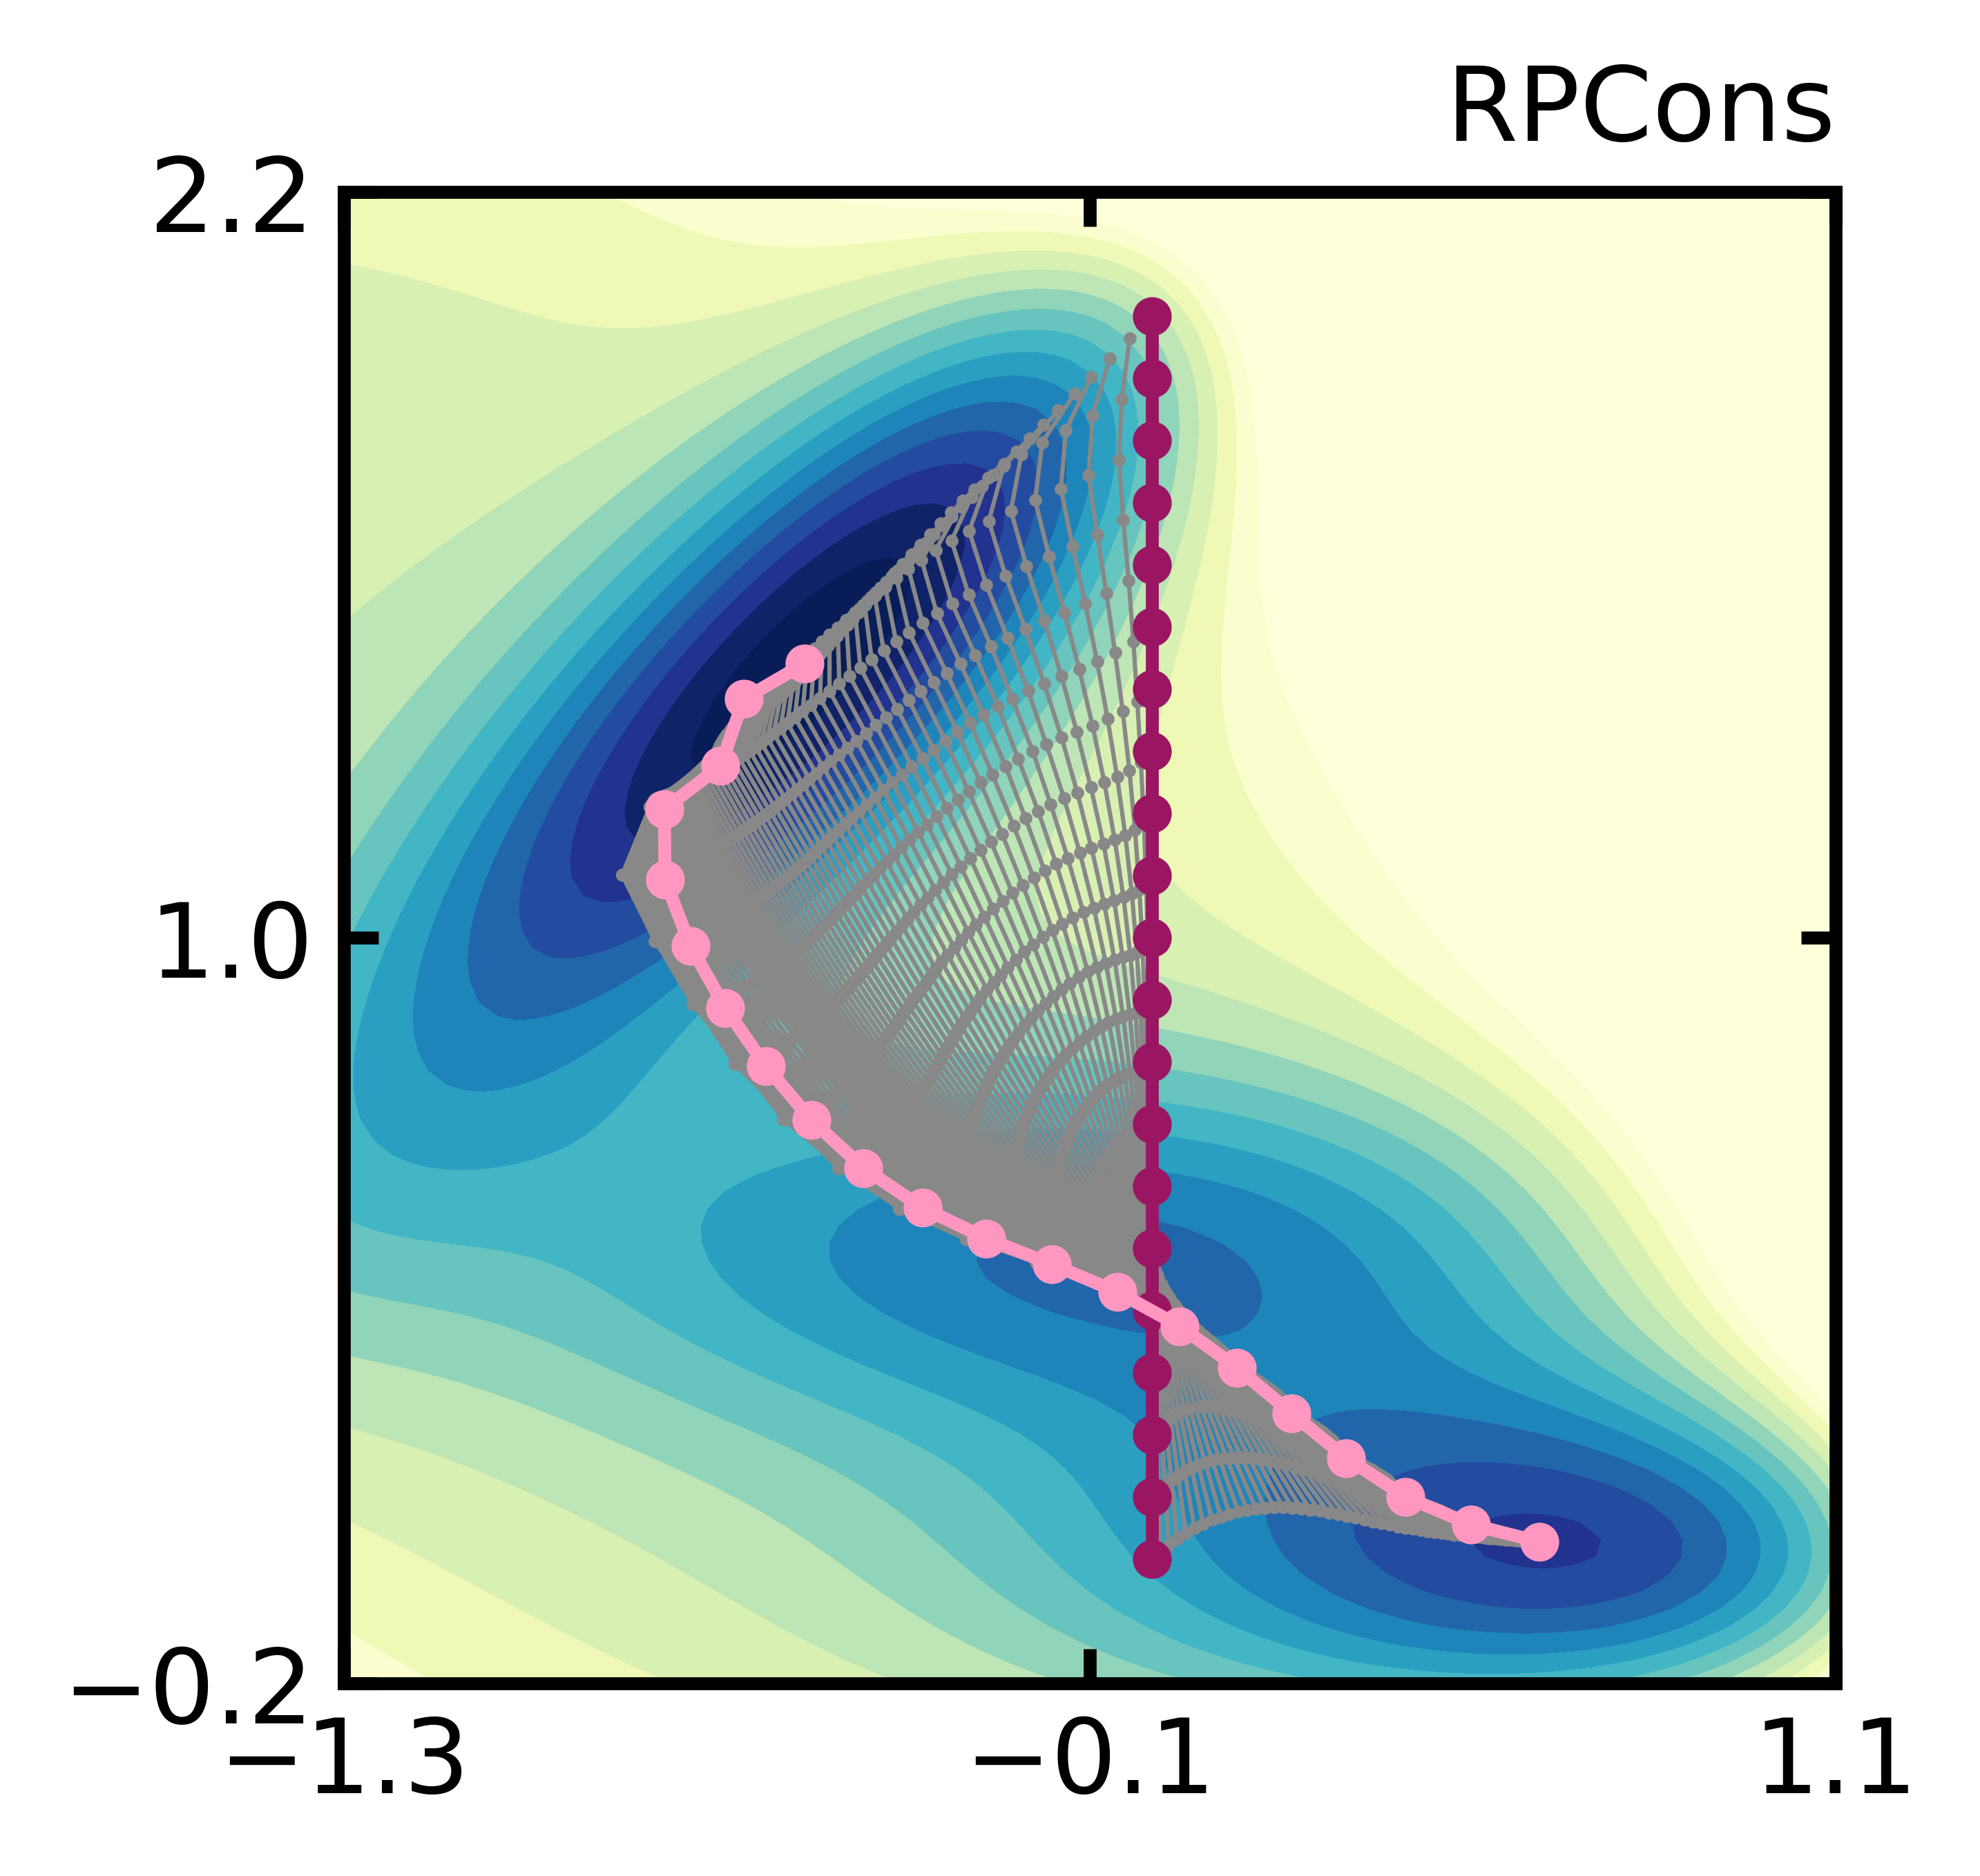

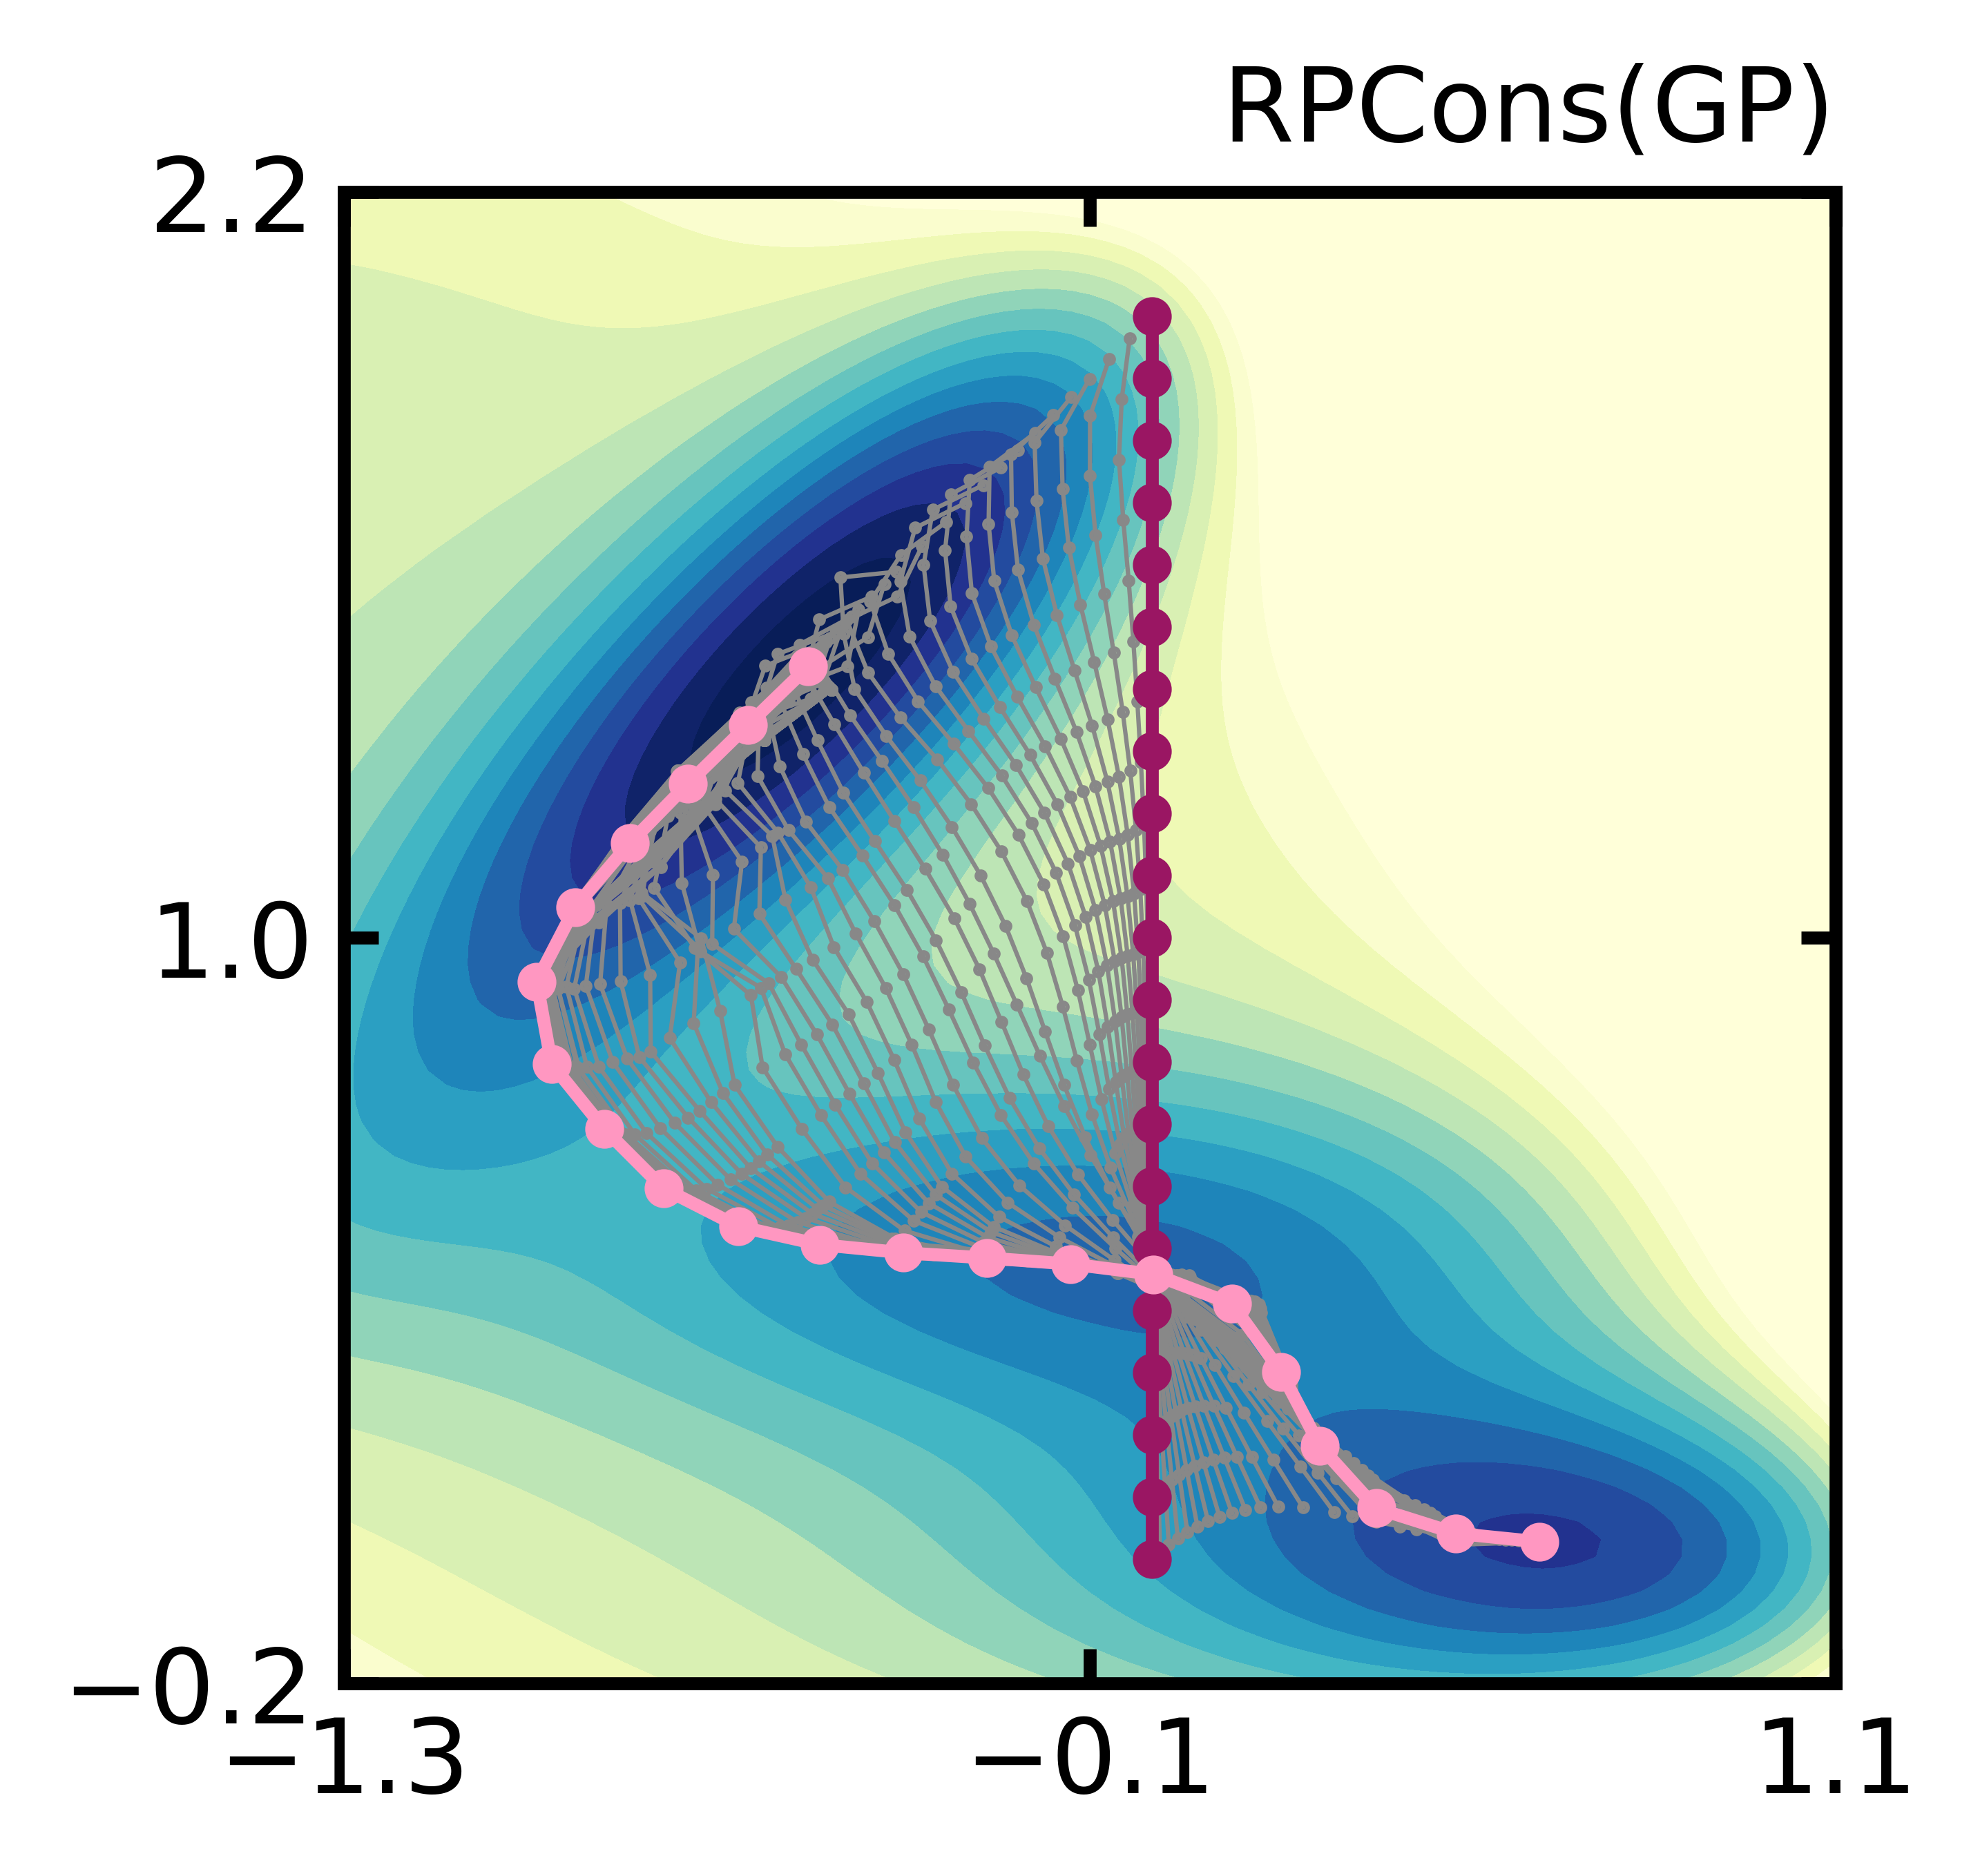

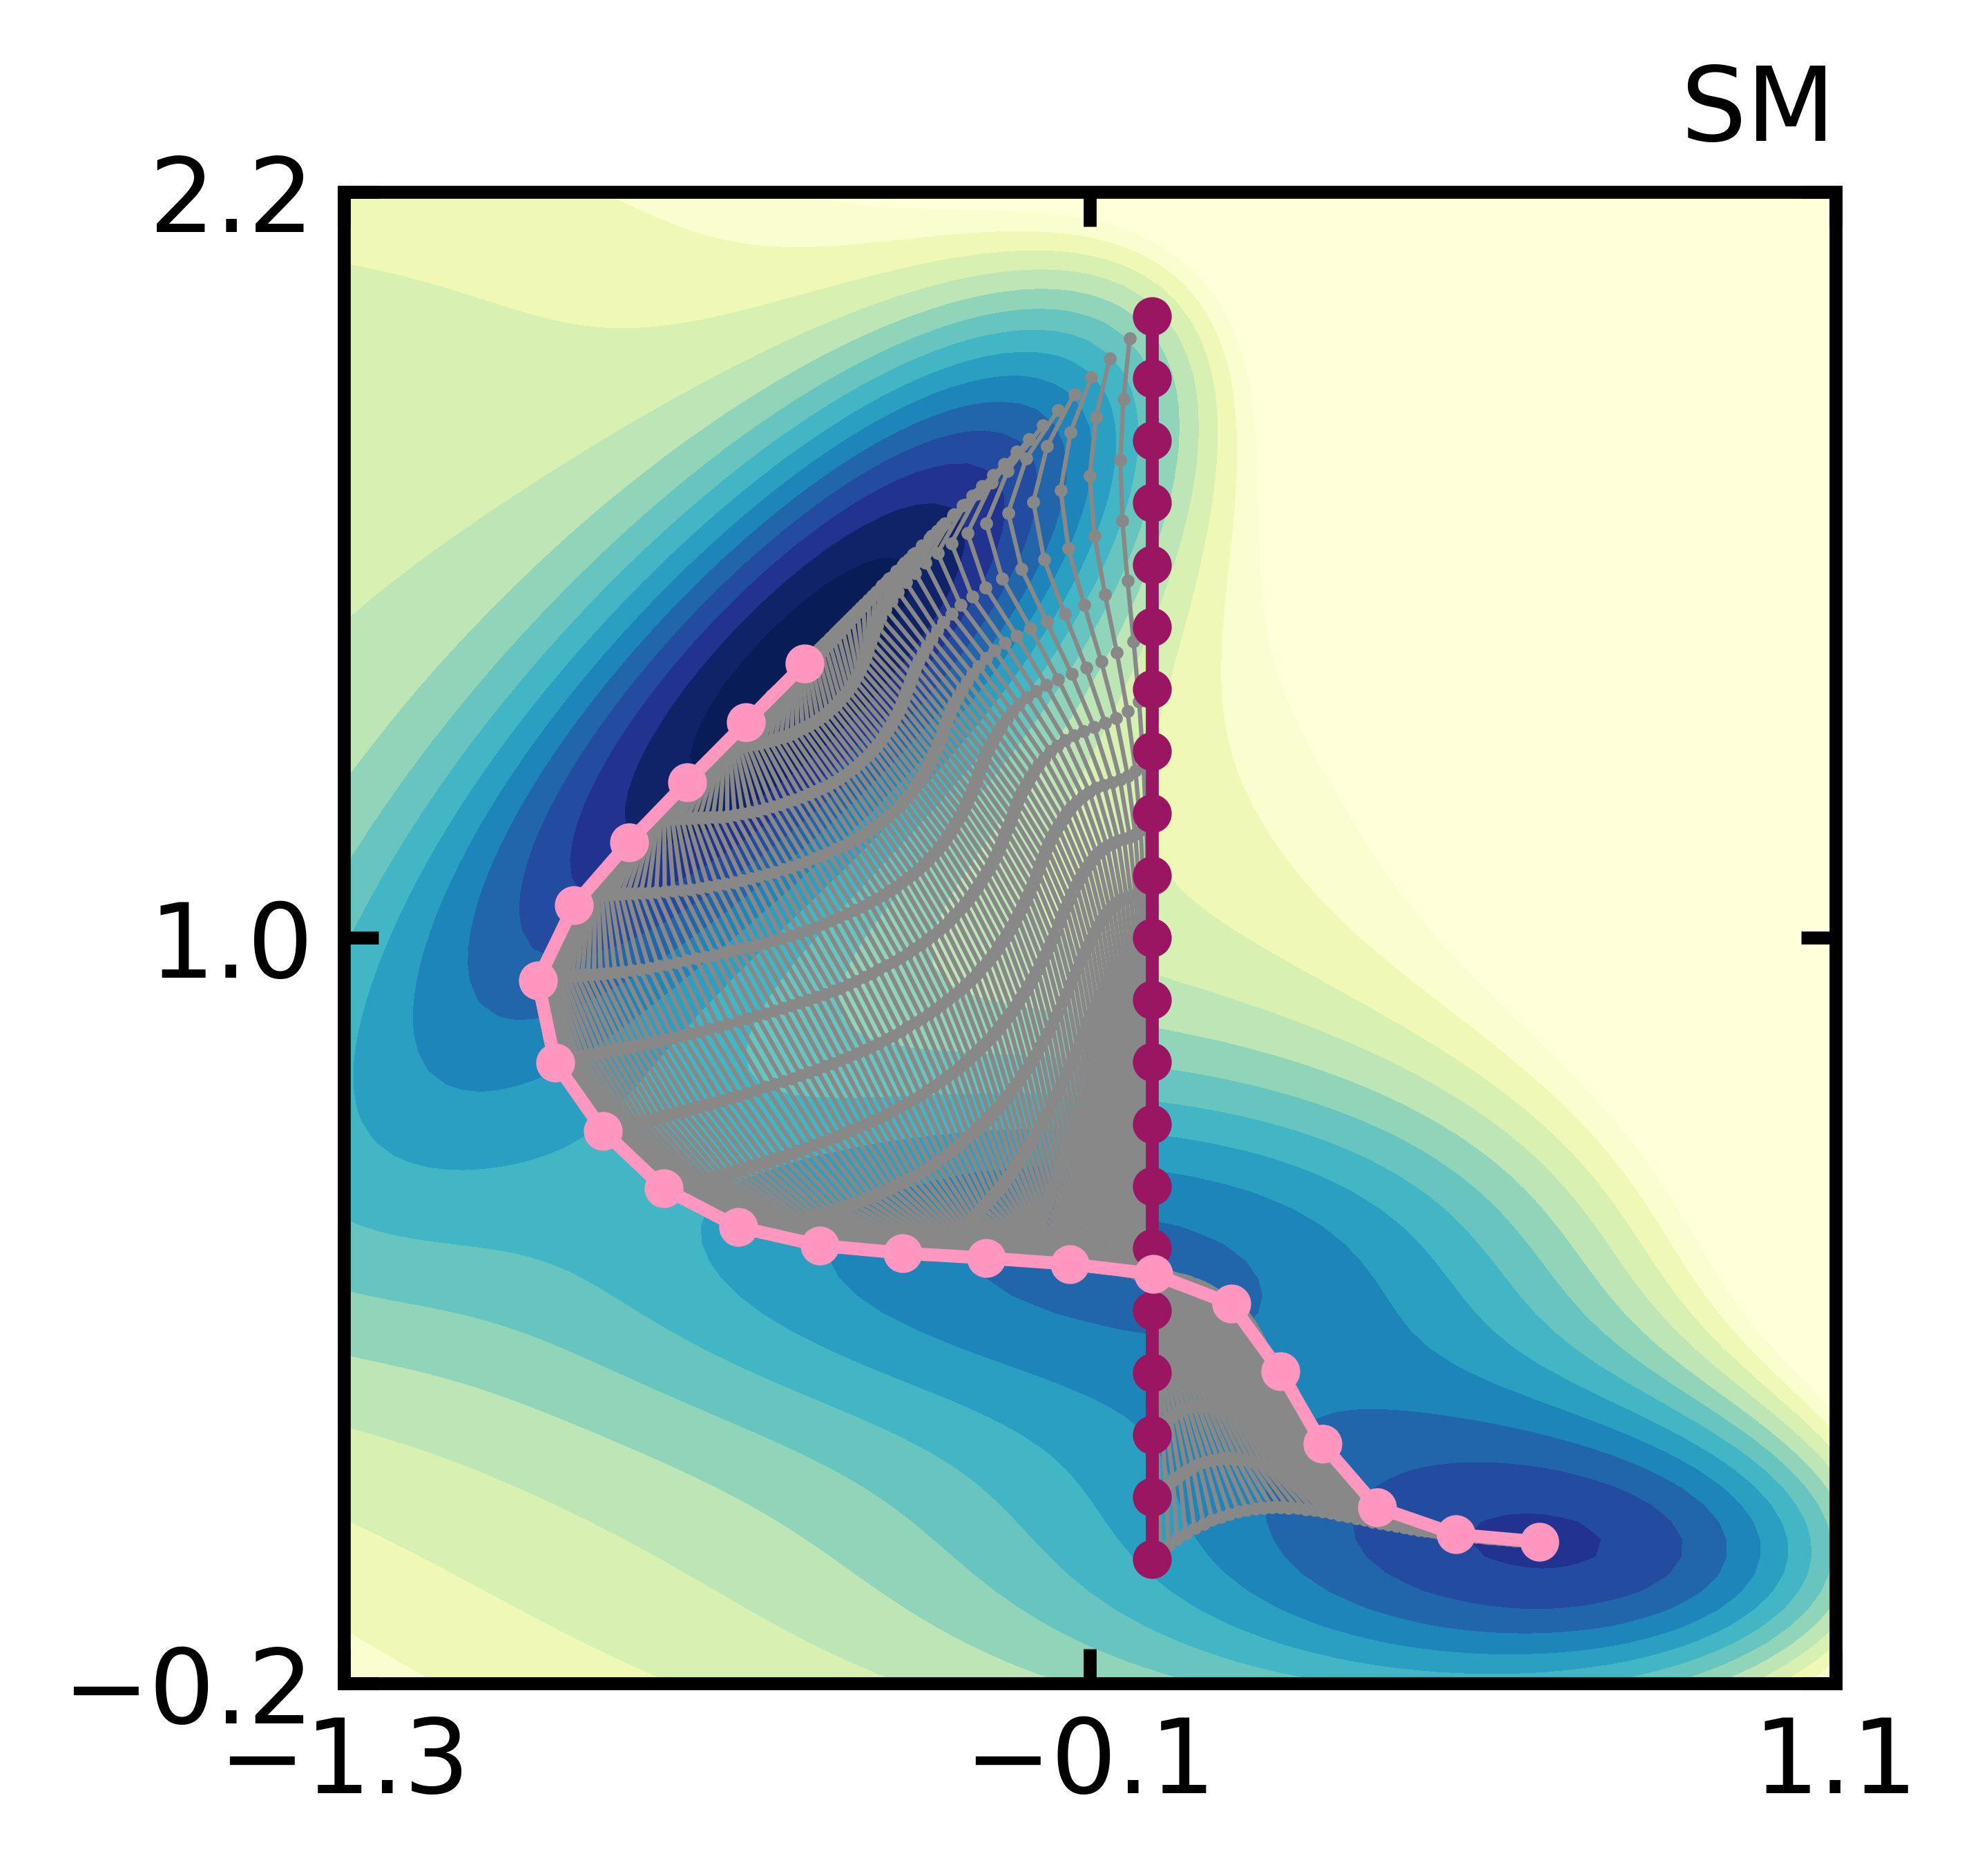

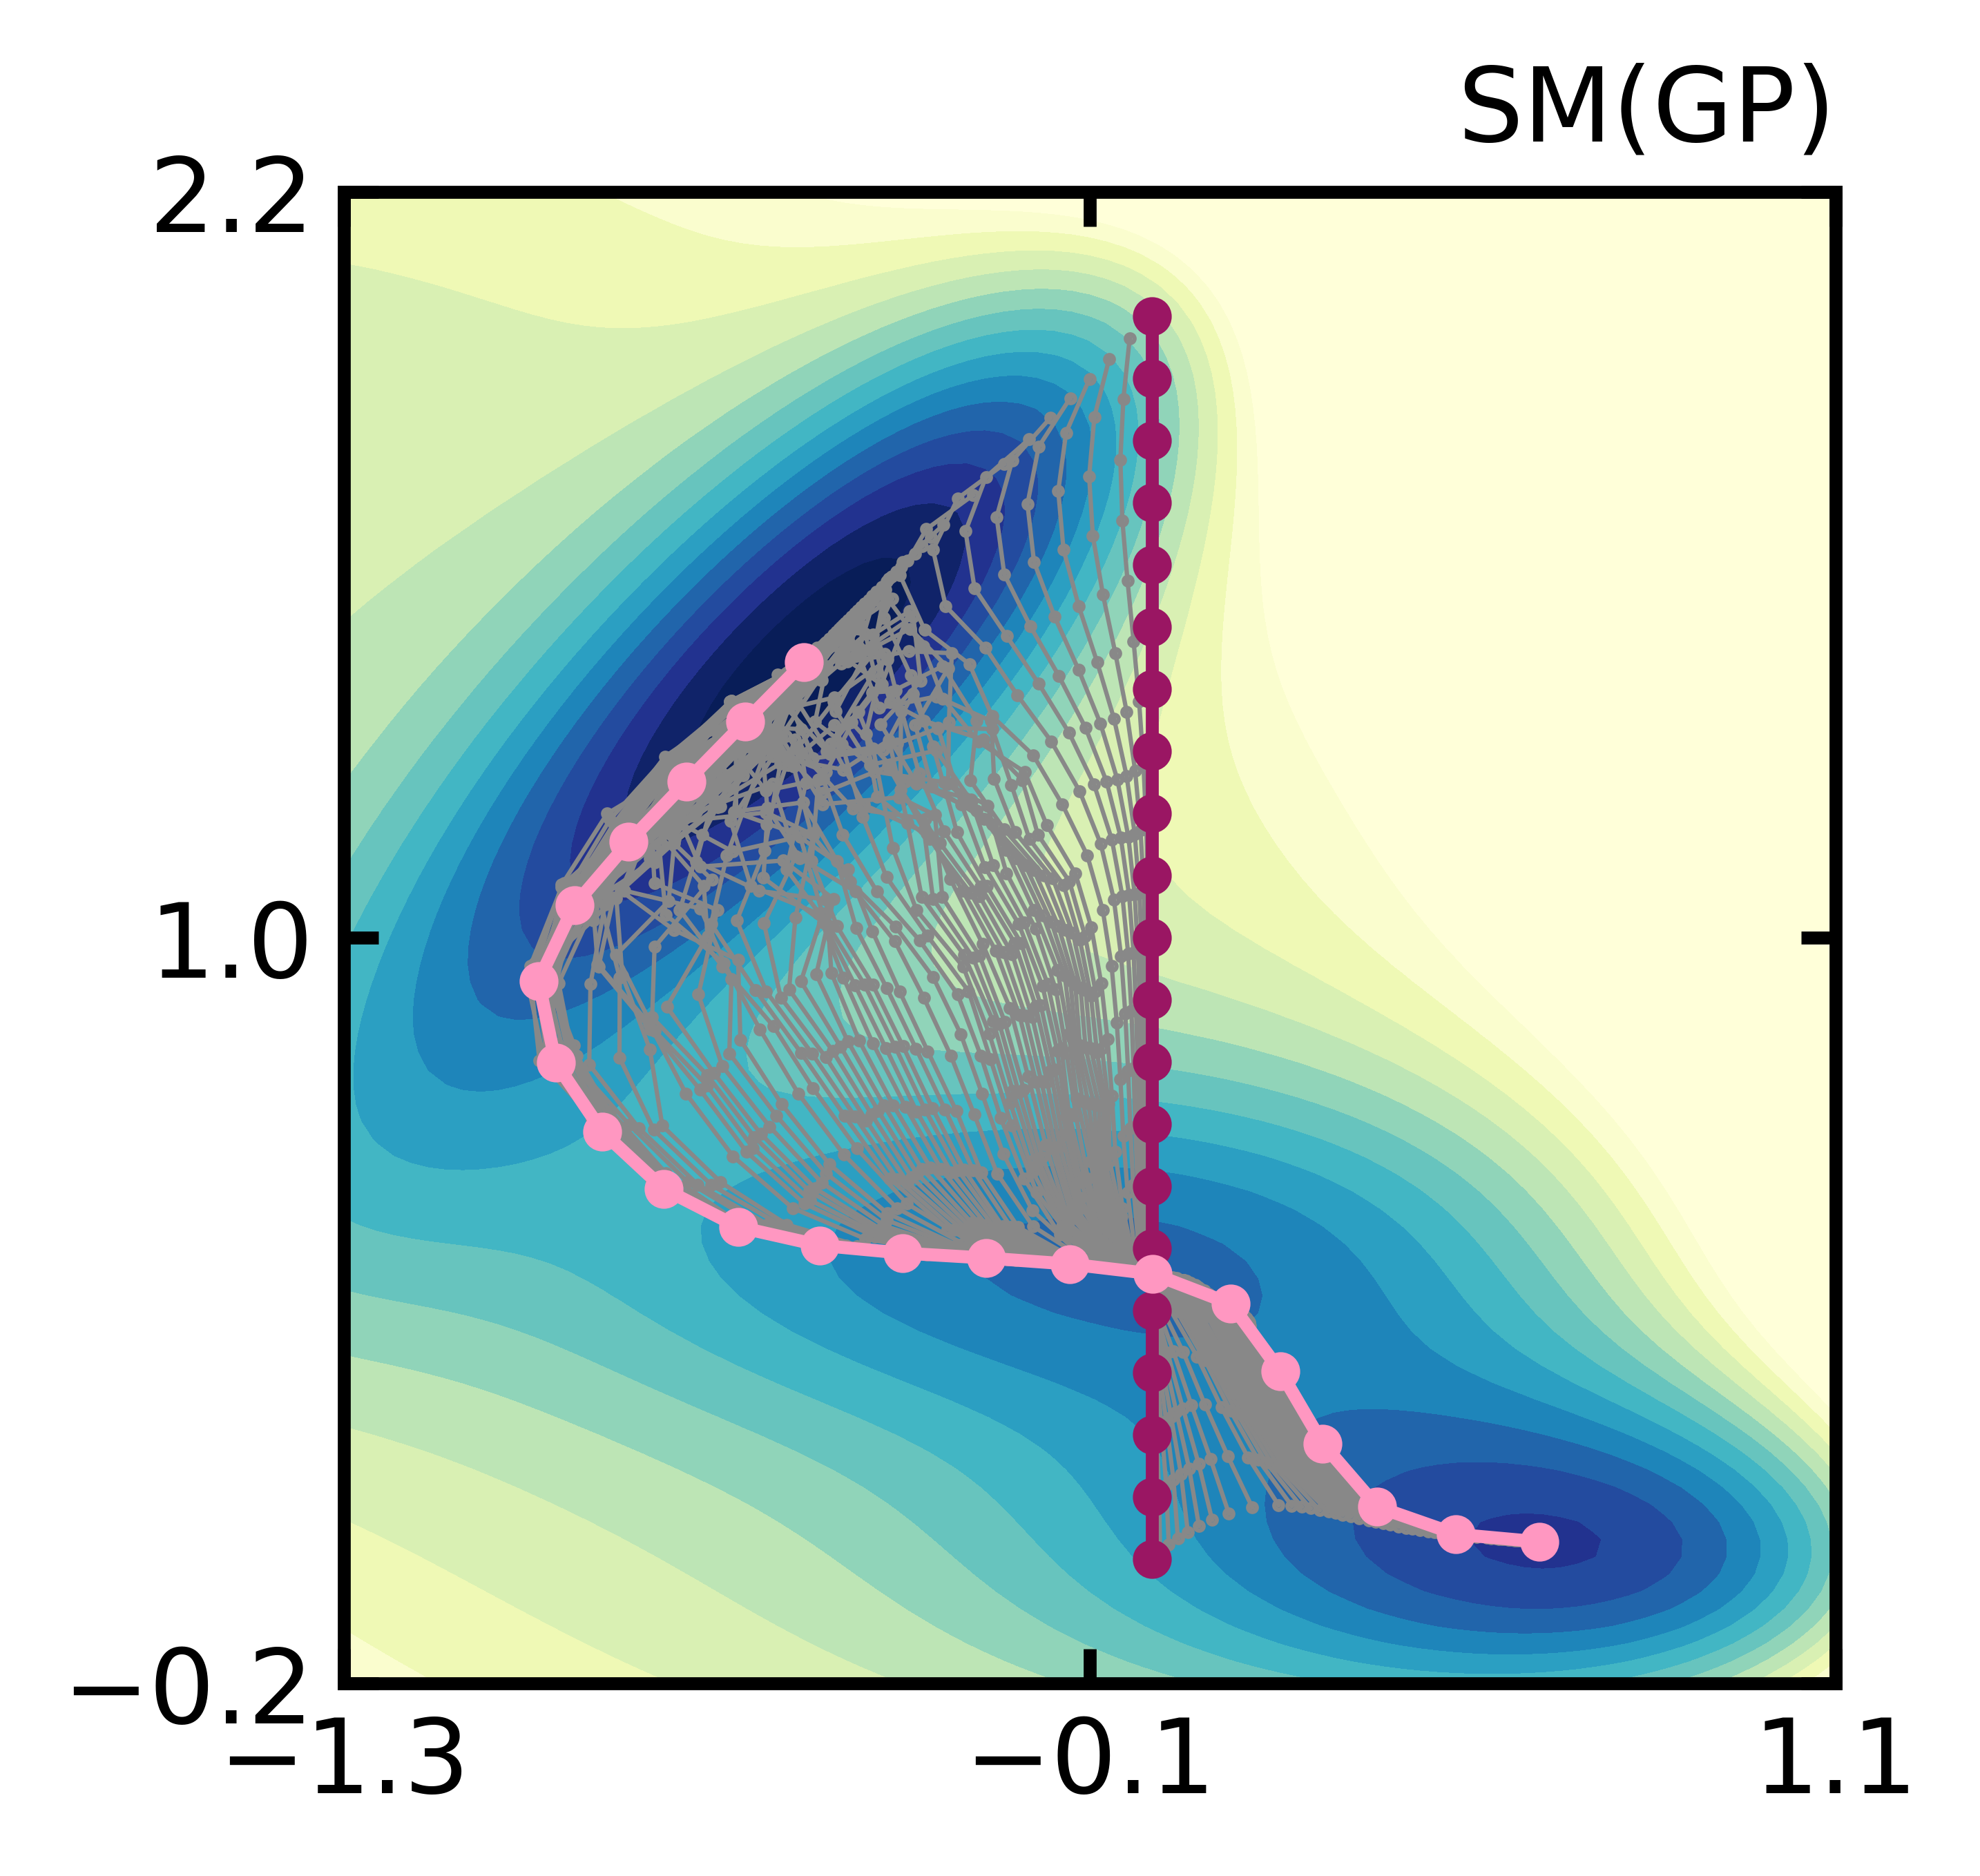

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax, v = plot_cvec(ax, out_car[0], out_car[1], out_car[2])
ax.set_title('CAR', fontdict={'fontsize':12}, loc='right')

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_car.jpeg')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax, v = plot_cvec(ax, out_carpt[0], out_carpt[1], out_carpt[2])
ax.set_title('CAR-PT', fontdict={'fontsize':12}, loc='right')

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_carpt.jpeg')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax, v = plot_cvec(ax, out_rpc[0], out_rpc[1], out_rpc[2])
ax.set_title('RPCons', fontdict={'fontsize':12}, loc='right')

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_rpcons.jpeg')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax, v = plot_cvec(ax, out_rpcgp[0], out_rpcgp[1], out_rpcgp[2])
ax.set_title('RPCons(GP)', fontdict={'fontsize':12}, loc='right')

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_rpconsgp.jpeg')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax, v = plot_cvec(ax, out_sm[0], out_sm[1], out_sm[2])
ax.set_title('SM', fontdict={'fontsize':12}, loc='right')

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_sm.jpeg')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax, v = plot_cvec(ax,  out_smgp[0],  out_smgp[1],  out_smgp[2])
ax.set_title('SM(GP)', fontdict={'fontsize':12}, loc='right')

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_smgp.jpeg')

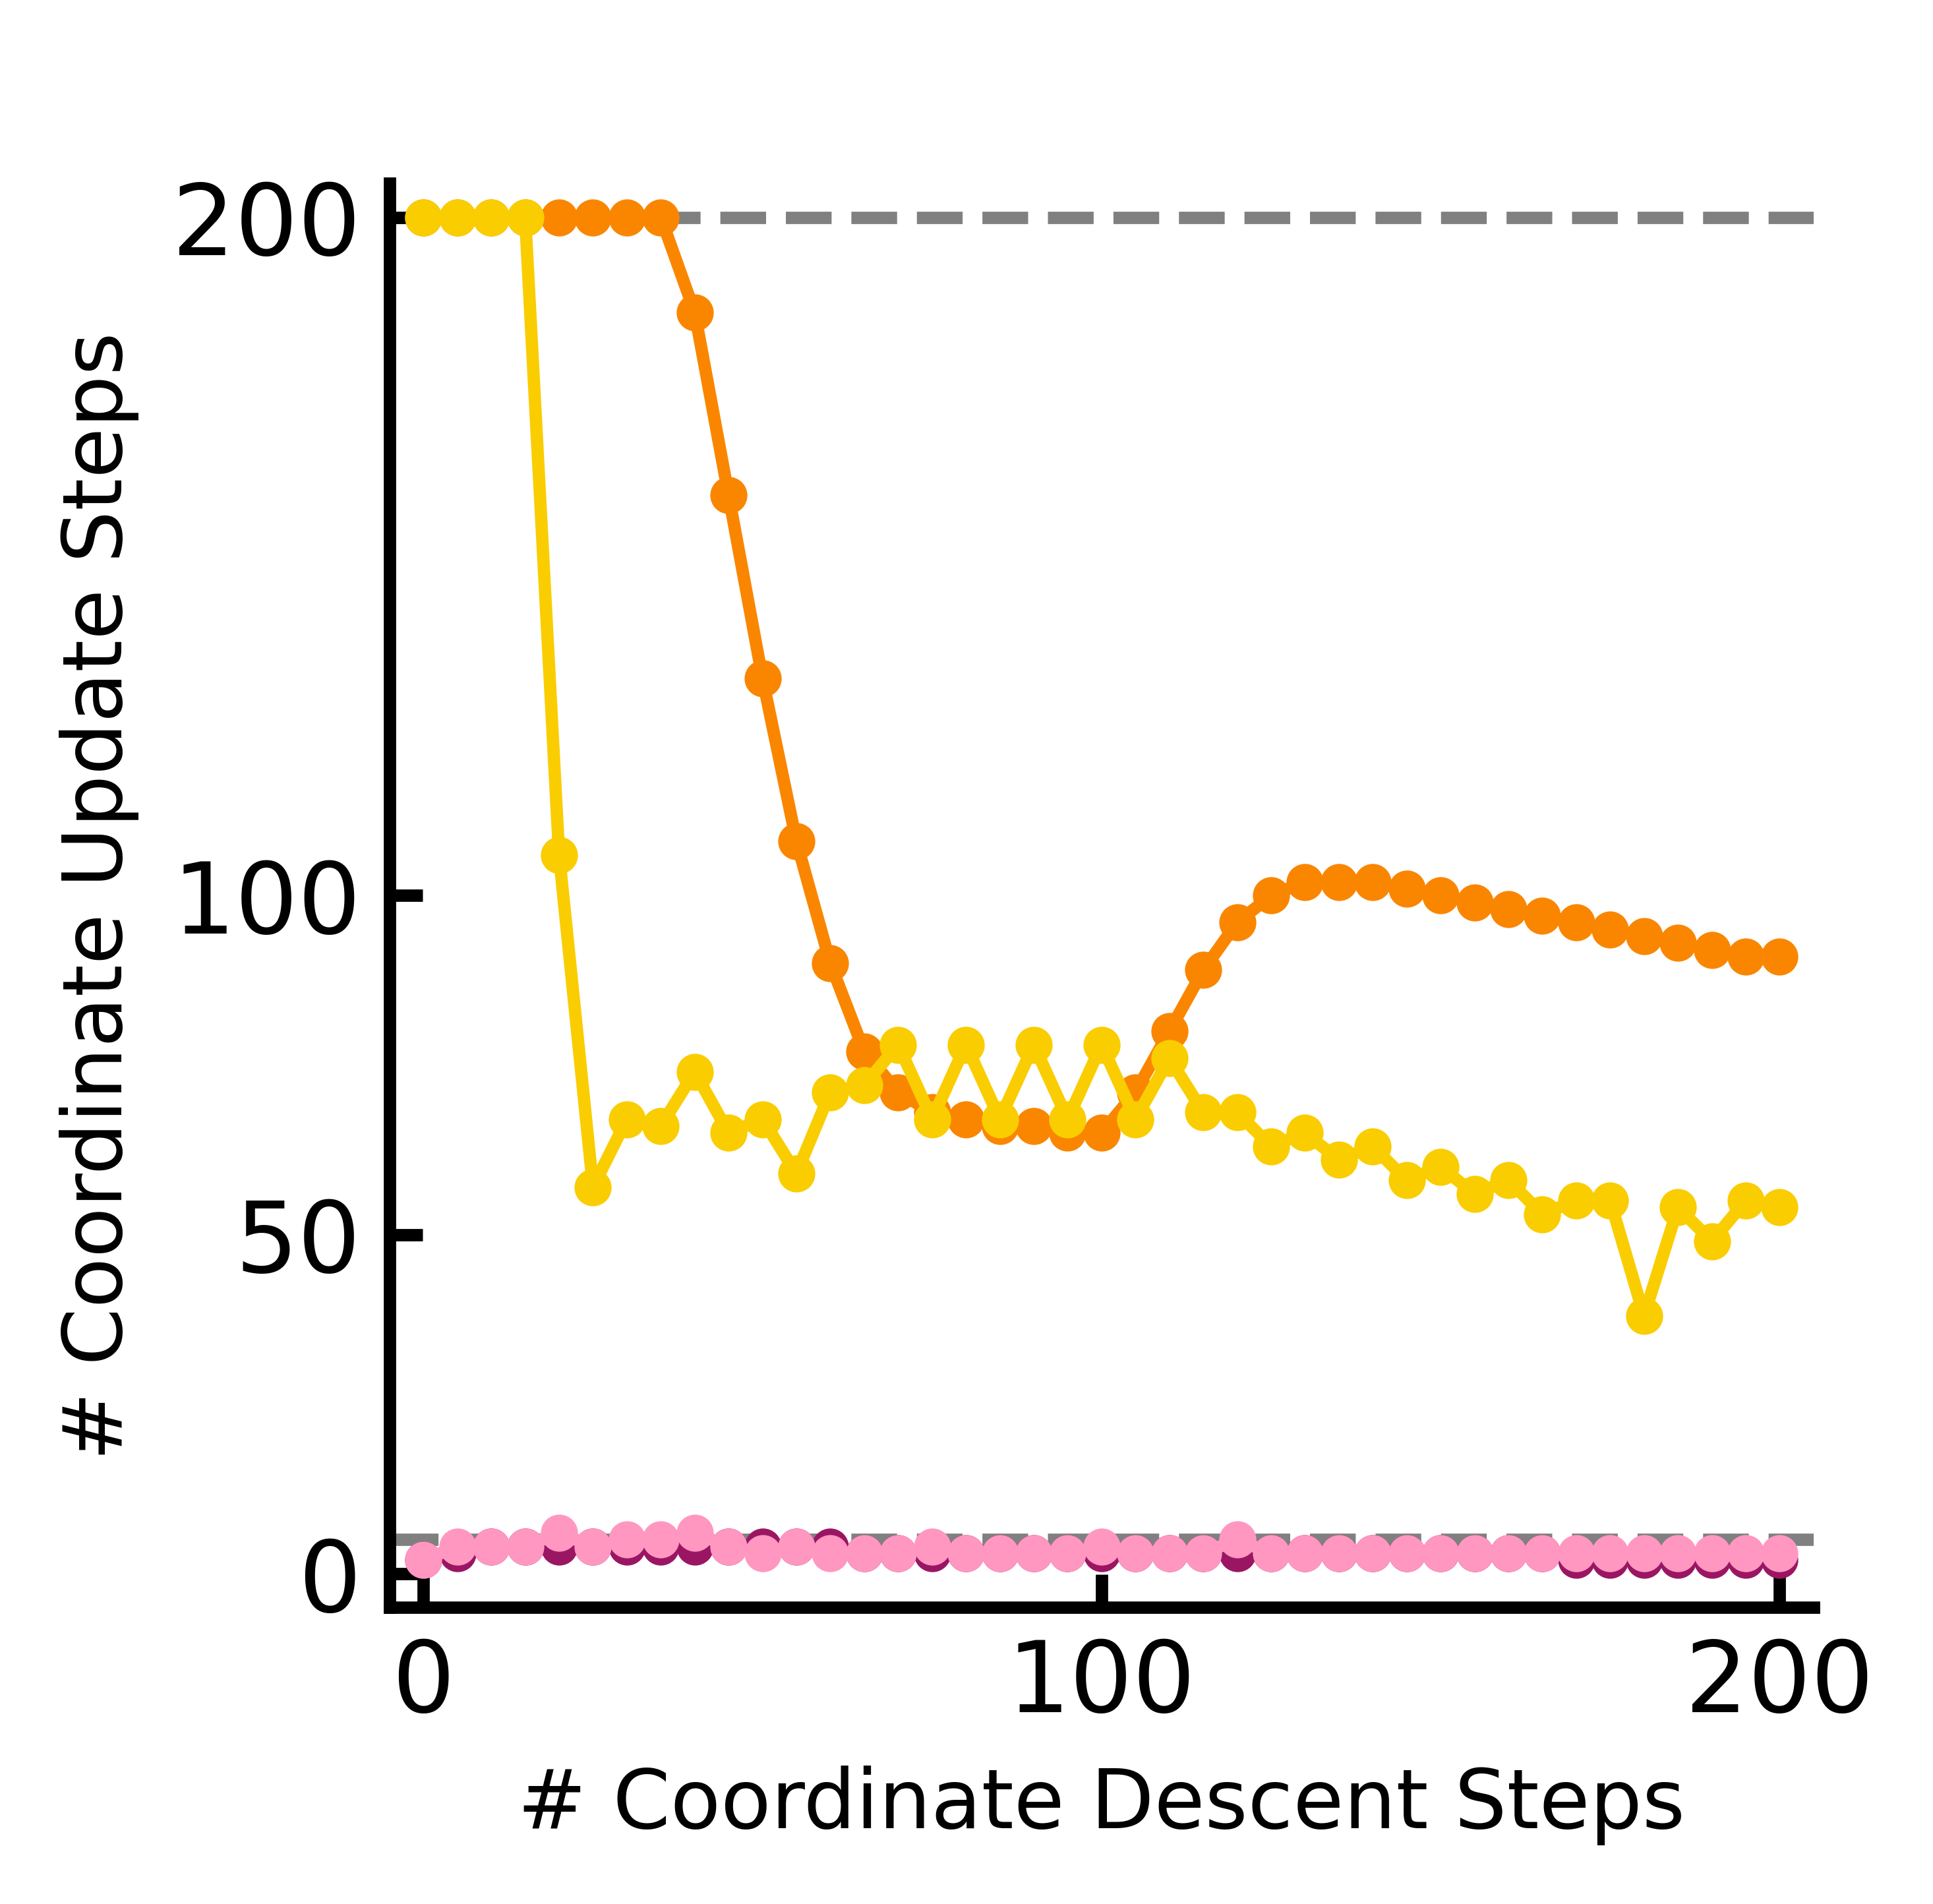

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4., bottom=1./4.)

ax.tick_params(direction='in', width=1.5, length=4, labelsize=12)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(" ")

    # ax.scatter(init[:, 0], init[:, 1], s=1., color="#219EBC", zorder=5)

    # # Plot trajectory of cvec.
    # for t in traj[::4]:
    #     ax.scatter(t[:, 0], t[:, 1], s=.2,  color="#434242", zorder=4)
    #     ax.plot(   t[:, 0], t[:, 1], lw=.3, color="#434242", zorder=4)
    
    # # Plot final cvec.
    # ax.scatter(finl[:, 0], finl[:, 1], s=1., color="#FF97C1", zorder=5)
# Fig. iterative update counts
ax.plot([-100, 300], [200,200], 'gray', ls='--', lw=1.5, zorder=0)
ax.plot([-100, 300], [5, 5],    'gray', ls='--', lw=1.5, zorder=0)

x = numpy.concatenate((numpy.arange(len(itr_coor_steps_car))[::5], [numpy.arange(len(itr_coor_steps_car))[::5][-1]+5]))
itr_coor_steps_car   = numpy.concatenate((itr_coor_steps_car  [0::5], [itr_coor_steps_car  [-1]]))
itr_coor_steps_carpt = numpy.concatenate((itr_coor_steps_carpt[0::5], [itr_coor_steps_carpt[-1]]))
itr_coor_steps_rpc   = numpy.concatenate((itr_coor_steps_rpc  [0::5], [itr_coor_steps_rpc  [-1]]))
itr_coor_steps_rpcgp = numpy.concatenate((itr_coor_steps_rpcgp[0::5], [itr_coor_steps_rpcgp[-1]]))

ax.plot(x, itr_coor_steps_car  , marker='.', markersize=7, color="#9A1663", label='CAR')
ax.plot(x, itr_coor_steps_carpt, marker='.', markersize=7, color="#FF97C1", label='CAR-PT')
ax.plot(x, itr_coor_steps_rpc  , marker='.', markersize=7, color="#FA8600", label='RPCons')
ax.plot(x, itr_coor_steps_rpcgp, marker='.', markersize=7, color="#FACD00", label='RPCons(GP)')

ax.set(xlim=(-5, 205), ylim=(-5, 205), xticks=[0, 100, 200], yticks=[0, 50, 100, 200])
ax.set_ylabel('# Coordinate Update Steps')
ax.set_xlabel('# Coordinate Descent Steps')
plt.savefig('./ms0_car/fig_muller/plot_muller_sd_itr_traj.jpeg')

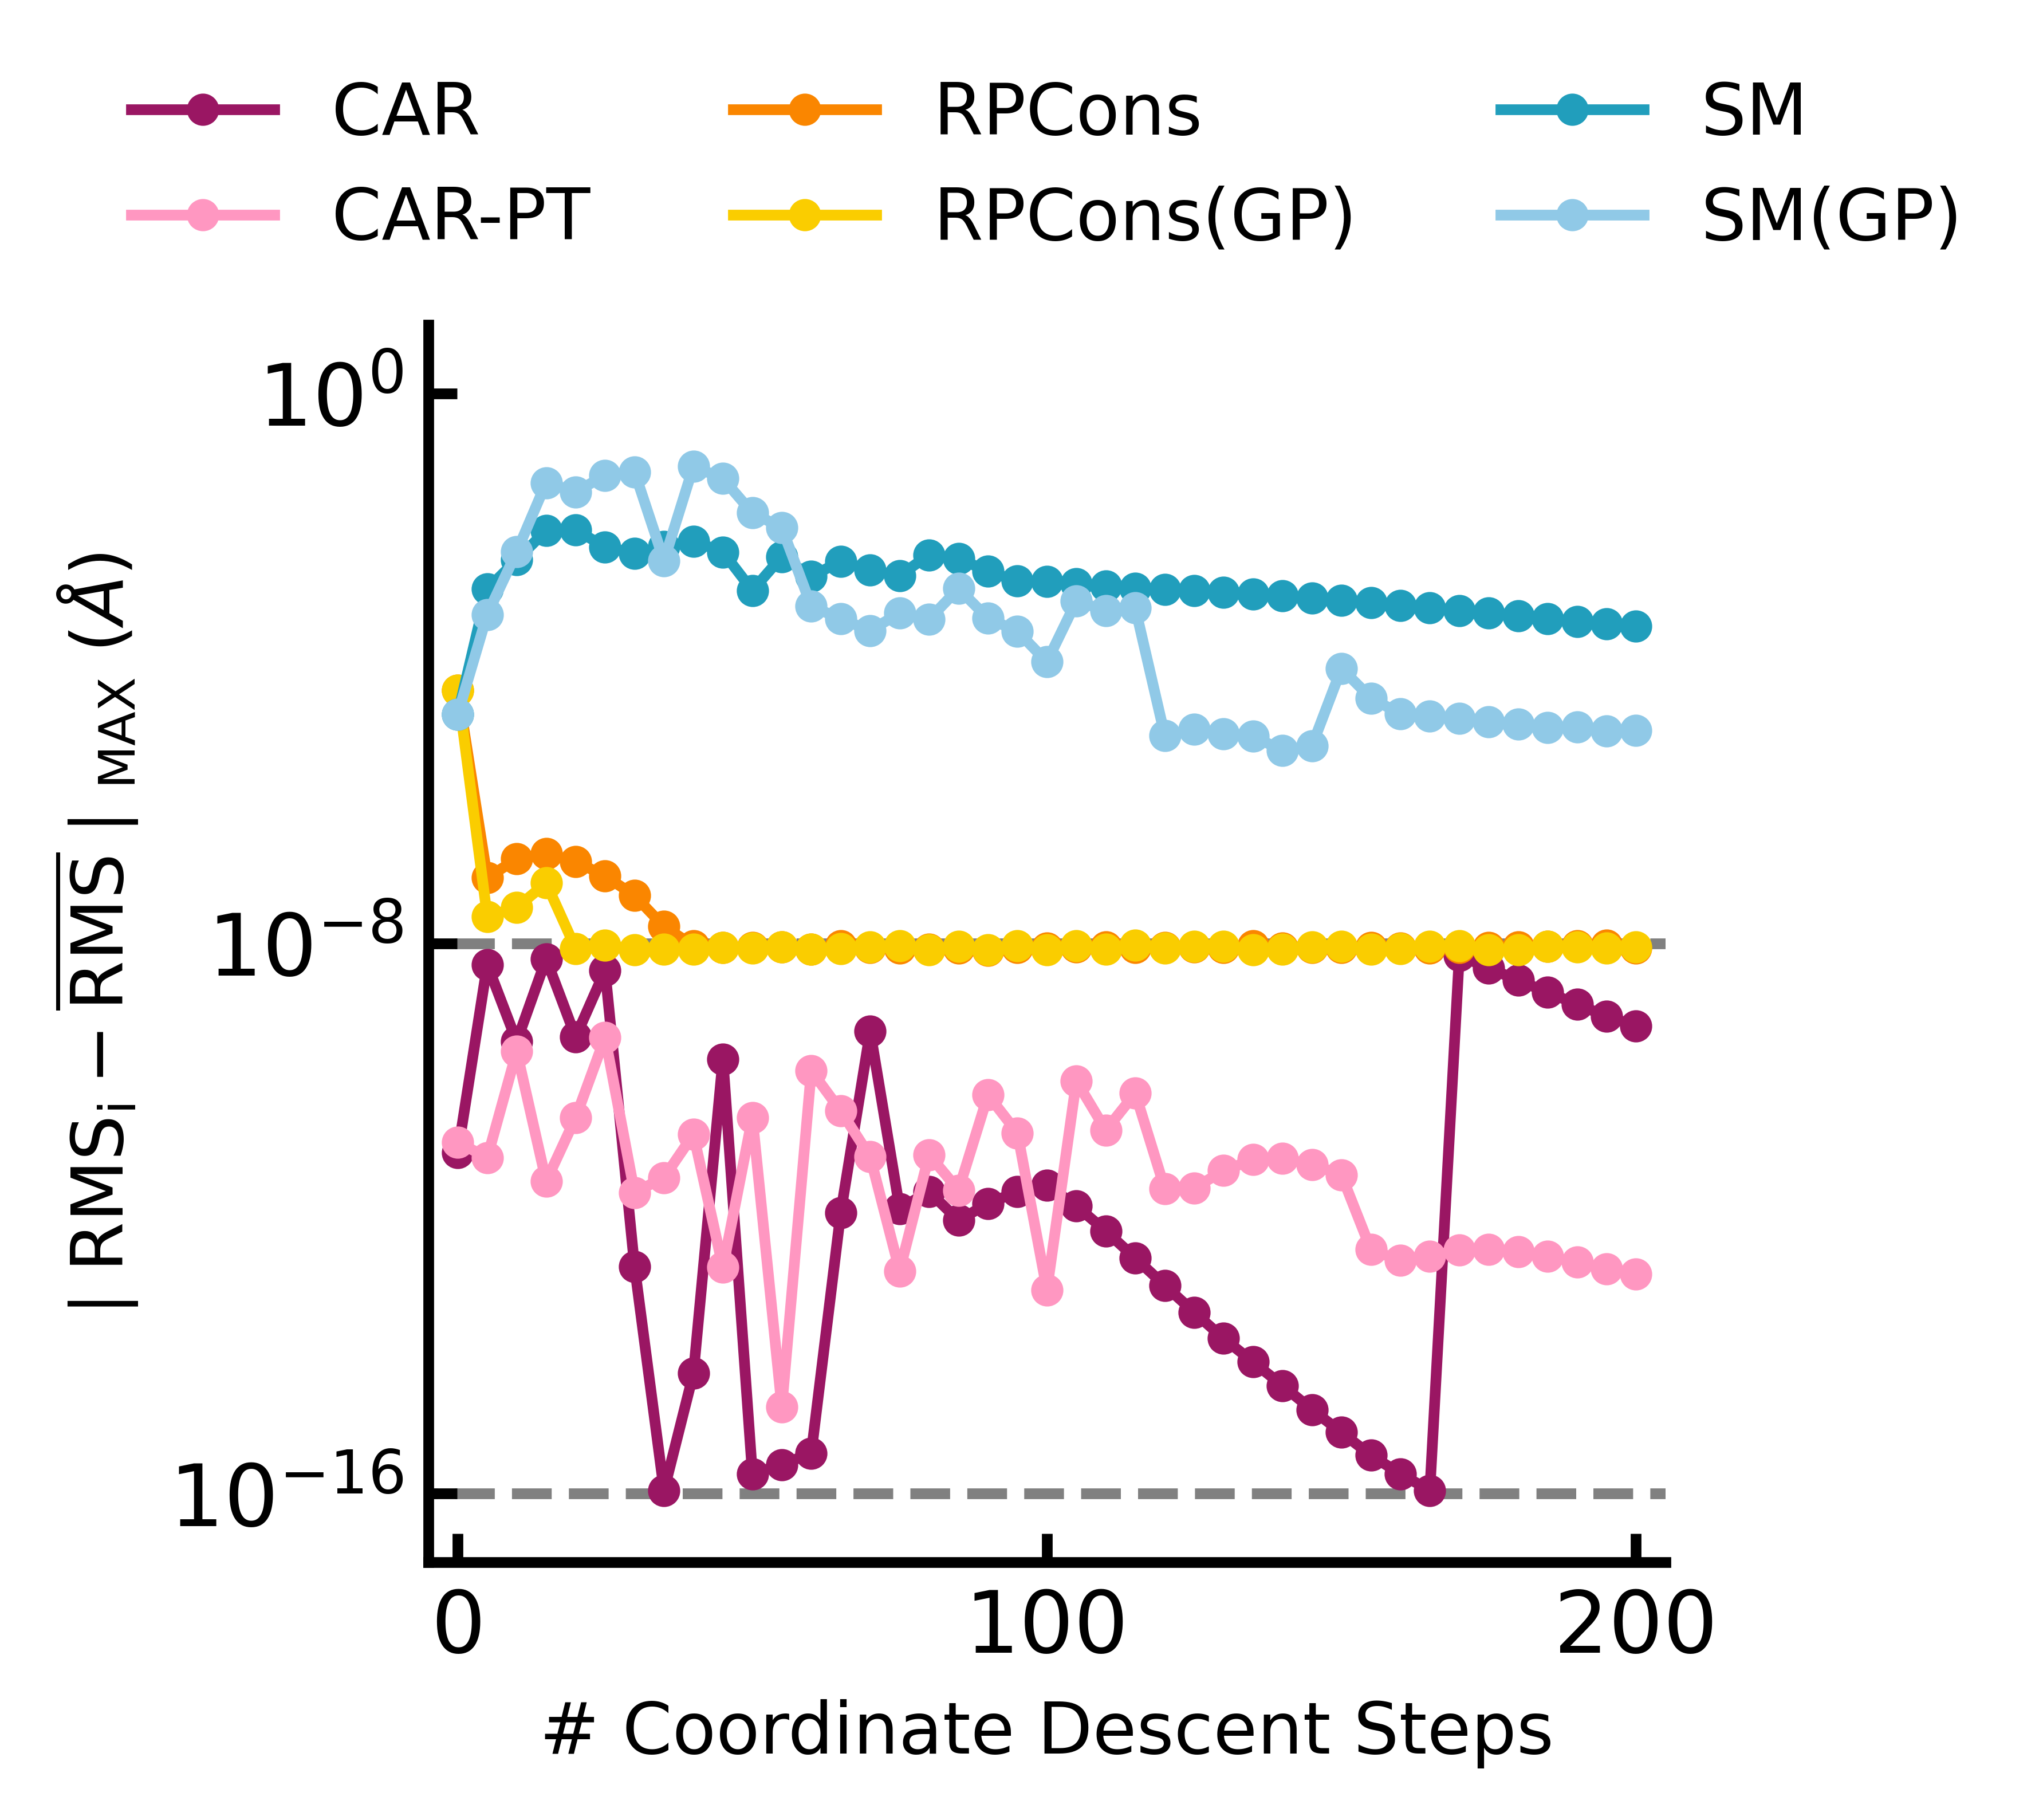

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4.5), dpi=900)
plt.subplots_adjust(left=1./4., right=3.4/4., top=3.4/4.5, bottom=1./4.5)

ax.tick_params(direction='in', width=1.5, length=4, labelsize=12)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(" ")

ax.plot([-100, 300], [1e-8,1e-8],   'gray', ls='--', lw=1.5, zorder=0)
ax.plot([-100, 300], [1e-16,1e-16], 'gray', ls='--', lw=1.5, zorder=0)

x = numpy.concatenate((numpy.arange(len(rms_dev_car))[::5], [numpy.arange(len(rms_dev_car))[::5][-1]+5]))
rms_dev_car   = numpy.concatenate((rms_dev_car  [0::5], [rms_dev_car  [-1]]))
rms_dev_carpt = numpy.concatenate((rms_dev_carpt[0::5], [rms_dev_carpt[-1]]))
rms_dev_rpc   = numpy.concatenate((rms_dev_rpc  [0::5], [rms_dev_rpc  [-1]]))
rms_dev_rpcgp = numpy.concatenate((rms_dev_rpcgp[0::5], [rms_dev_rpcgp[-1]]))
rms_dev_sm    = numpy.concatenate((rms_dev_sm   [0::5], [rms_dev_sm   [-1]]))
rms_dev_smgp  = numpy.concatenate((rms_dev_smgp [0::5], [rms_dev_smgp [-1]]))

ax.plot(x, rms_dev_car  , color="#9A1663", marker='.', markersize=7, label='CAR',       )
ax.plot(x, rms_dev_carpt, color="#FF97C1", marker='.', markersize=7, label='CAR-PT',    )
ax.plot(x, rms_dev_rpc  , color="#FA8600", marker='.', markersize=7, label='RPCons',    )
ax.plot(x, rms_dev_rpcgp, color="#FACD00", marker='.', markersize=7, label='RPCons(GP)',)
ax.plot(x, rms_dev_sm   , color="#219EBC", marker='.', markersize=7, label='SM',        )
ax.plot(x, rms_dev_smgp , color="#90C9E7", marker='.', markersize=7, label='SM(GP)',    )

ax.set(xlim=(-5, 205), 
       ylim=(1e-17, 10.), yscale='log', yticks=[1e-16, 1e-8, 1])
ax.set_xlabel('# Coordinate Descent Steps')
ax.set_ylabel(r'$\mathrm{\mid RMS_{i}-\overline{RMS}\mid_{MAX}}$ ($\AA$)')

leg = plt.legend(loc="upper center", bbox_to_anchor=(.5, 1.25), frameon=False, ncol=3, )

plt.savefig('./ms0_car/fig_muller/plot_muller_sd_rms_traj.jpeg')
